# Analysis of cell count per organoid
*Author: Felix Romer*<br/>
*Data: 27/02/2024*<br/>
<br/>
The underlying data is spinning disc microscopy data of organoids, stained with DAPI. Because of technical problems (strong bleaching for nuclei in lower half of organoids) only the top half of the organoids were counted. The radius in z as well as the diameter in x and y direction where measured. With that the surface of the ellipsoid describing the organoid will be calculated.<br/>
For some organoid the attempt was made to calculate all cells. This was often not too successful. 14 organoids were completely segmented and used to verify the approach. Nested statistical test were performed in R.

## 1. Set up
Imports, data loading, global variables  

In [44]:
# Import needed packages
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.special import ellipkinc, ellipeinc
from functions import ellipsoid_surface_area, calculate_difference
from matplotlib.legend_handler import HandlerTuple

#statistic
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Design
sns.set_context('notebook', font_scale=1.2)

# Load data
file_loc = 'Confocal image metrics data.xlsx'
Data = pd.read_excel(file_loc)

# global variables
CF_xy = 1       # is already in µm
CF_z  = 2.25

## 2. Process data
* extract experiment conditions
* calculate ellipsoid surface area
* calculate other features of interest

In [26]:
# Define a regular expression to extract one and two-digit numbers within text
# First number corresponds to the biological replication (different animal)
# Second number corresponds to the technical replication (different slide)
# Third number corresponds to the organoid number
pattern = r'(?<!\d)(\d{1,2})(?!\d)'

# Extract meta data from Name column
Data['Replication']             = Data['Name'].str.findall(pattern).str[0].astype(int)
Data['Slide_number']            = Data['Name'].str.findall(pattern).str[1].astype(int)
Data['Organoid_number']         = Data['Name'].str.findall(pattern).str[2].astype(int)
Data['Category']                = Data['Name'].apply(lambda x: 'Control' if 'Control' in x else 'H. pylori')
Data['Infection_time']          = Data['Name'].apply(lambda x: 'Early life' if 'Early life' in x else 'Late life')
Data['Condition']               = Data['Infection_time'] + " " + Data['Category']
Data['Condition_2']              = Data['Condition'] + " " + Data["Replication"].astype('str')

# Scale data
Data['number slices top half']  = Data['number slices top half'].apply(calculate_difference)
Data['dz']                      = Data['number slices top half'] * CF_z

# Calculate surface of ellipsoid
Data['Ellipsoid_surface_area']  = Data.apply(lambda row: ellipsoid_surface_area(row['dz']*2, row['small diameter µm'], row['biggest diameter µm']), axis=1) /100000000

# Transform features of interest to log space
Data['cells_per_area']          = Data['number cells top half'] / Data['Ellipsoid_surface_area'] * 2
Data['cells_per_area_log']      = np.log(Data['cells_per_area'])
Data['n_cells_log']             = np.log(Data['number cells top half'])
Data['Ellipsoid_surface_area_log'] = np.log(Data['Ellipsoid_surface_area'])


# Remove untrusted data points
DataTrusted = Data[Data['Data trustable'] == "Yes"]

# Get Organoids that are compleat segmented
DataVerify = DataTrusted[DataTrusted['Note'].notna() &
                         DataTrusted['Note'].str.contains('good|Good|compleat', case=False, na=False) &
                         ~ DataTrusted['Note'].str.contains('bad|Bad|bleaching', case=False, na=False)]



### 2.1 Save Dataset

In [3]:
name = file_loc.split('.')[0] + '_DataVerified.csv'
DataVerify.to_csv(name)

In [4]:
name = file_loc.split('.')[0] + '_DataTrusted.csv'
DataTrusted.to_csv(name)

#### 2.2 View Dataset

In [5]:
DataVerify.columns

Index(['Name', 'Experiment', 'Group', 'number slices top half',
       'small diameter µm', 'biggest diameter µm', 'number cells top half',
       'note for top half', 'Data trustable', 'number cells', 'Note',
       'Replication', 'Slide_number', 'Organoid_number', 'Category',
       'Infection_time', 'Condition', 'dz', 'Ellipsoid_surface_area',
       'cells_per_area', 'cells_per_area_log', 'n_cells_log',
       'Ellipsoid_surface_area_log'],
      dtype='object')

## 3. Verify if half aproach works


### 3.1 Filter

In [4]:
# Drop rows with NaN values in the specified columns
filtered_data = DataVerify[DataVerify['number cells top half'].notna() & DataVerify['number cells'].notna()]

# Convert the columns to numeric, handling non-numeric values
filtered_data['number cells top half'] = pd.to_numeric(filtered_data['number cells top half'], errors='coerce')
filtered_data['number cells'] = pd.to_numeric(filtered_data['number cells'], errors='coerce')


### 3.2 Visualize

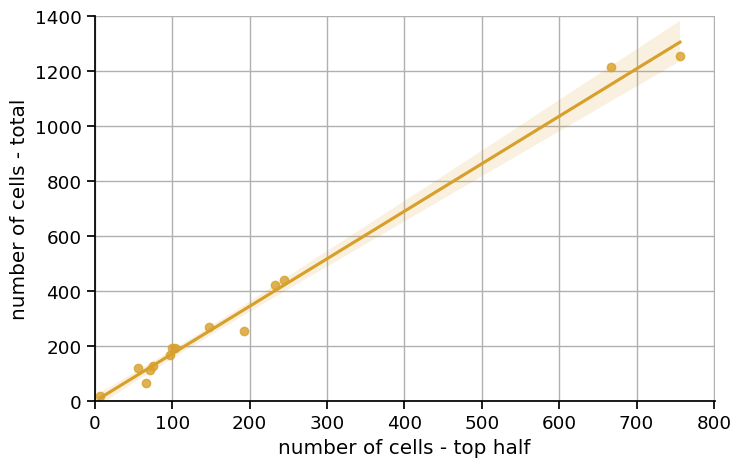

Regression Equation: y = -0.21 + 1.73 * x
R-squared: 0.99


c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  k, _ = kurtosistest(a, axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           number cells   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1383.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           9.16e-14
Time:                        11:30:22   Log-Likelihood:                -69.728
No. Observations:                  14   AIC:                             143.5
Df Residuals:                      12   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2072     13.812     -0.015      0.988     -30.301      29.887
number cells top half     1.7274      0.046     37.193      0.000       1.626       1.829
==============================================================================
Omnibus:                        2.726   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                1.294
Skew:                          -0.743   Prob(JB):                        0.524
Kurtosis:                       3.110   Cond. No.                         404.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
fig, ax1 = plt.subplots(figsize=(8,5))
sns.regplot(data = filtered_data,
            x = 'number cells top half',
            y = 'number cells', color = '#D8A02B',
            ax=ax1)
# Add grid
ax1.grid()
ax1.set_axisbelow(True)
ax1.set_ylabel('number of cells - total')
ax1.set_xlabel('number of cells - top half')
ax1.set_ylim(0,1400)
ax1.set_xlim(0,801)



# Remove spine
for s in ["top", "right"]:
    ax1.spines[s].set_visible(False)
# Perform the linear regression
X = sm.add_constant(filtered_data['number cells top half'])  # Add a constant term to the predictor
y = filtered_data['number cells']

model = sm.OLS(y, X).fit()

# plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.show()


# Get the regression results summary
summary_text = f"Regression Equation: y = {model.params['const']:.2f} + {model.params['number cells top half']:.2f} * x\nR-squared: {model.rsquared:.2f}"
print(summary_text)
display(model.summary())


## 4. Analysis of size and cell count
The untransformed and the log transformed data is shown

### 4.1 Statistics
Perform a test with:
* **Response:** log(cell count) or log(area) 
* **Predictor:** Infectiontimepoint and Infection or Control
* **Random effect:** Repition

In [45]:
for feature in ['n_cells_log', 'Ellipsoid_surface_area_log']:

    # Load your data (assuming you have a DataFrame called 'summary_od_Day6')
    # Make sure 'log_Area_median' and 'count' columns exist in your data

    # Fit the LME model
    random_effect   = "Replication"
    formula         = feature + " ~ Condition"
    lme_model       = smf.mixedlm(formula, data=DataTrusted, groups=DataTrusted[random_effect])

    # Get the results summary
    lme_results = lme_model.fit(method=["lbfgs"])

    # Print the summary
    print("Results for: ", feature)
    display(lme_results.summary())


Results for:  n_cells_log


c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: Co

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                   MixedLM       Dependent Variable:       n_cells_log
No. Observations:        150           Method:                   REML       
No. Groups:              2             Scale:                    2.3251     
Min. group size:         68            Log-Likelihood:           inf        
Max. group size:         82            Converged:                Yes        
Mean group size:         75.0                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.000                                    
Condition[T.Early life H. pylori]  0.293    0.296  0.992 0.321 -0.286  0.873
Condition[T.Late life Control]    -0.484    0.631 -0.768 0.443 -1.720  0.752
Group Var                          0.000                                    
============================================================================

"""

Results for:  Ellipsoid_surface_area_log


c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: Co

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:              MixedLM  Dependent Variable:  Ellipsoid_surface_area_log
No. Observations:   150      Method:              REML                      
No. Groups:         2        Scale:               1.3852                    
Min. group size:    68       Log-Likelihood:      inf                       
Max. group size:    82       Converged:           Yes                       
Mean group size:    75.0                                                    
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.000                                    
Condition[T.Early life H. pylori]  0.215    0.228  0.940 0.347 -0.233  0.662
Condition[T.Late life Control]    -0.534    0.487 -1.097 0.272 -1.488  0.420
Group Var                          0.000                                    
============================================================================

"""

##### Interpretation of result
**Cell number:**
<br>
* **Group Var:** The value (0.000) shows that there is **no significant random effect** from the repition.
* **Intercept:** The estimated intercept when the condition is the reference category (Early life Control). Since the p-value is not significant, we don’t have strong evidence to reject the null hypothesis that the intercept is zero.
* **Condition[T.Early life H. pylori]:** This coefficient represents the difference in the n_cells_log between Early life H. pylori and Early life Control. The positive value (0.293) suggests that Early life H. pylori has a **slightly higher n_cells_log** compared to the reference category (Early life Control). However, the p-value (0.321) indicates that this difference is **not statistically significant**.
* **Condition[T.Late life Control]:** This coefficient represents the difference between Late life Control and Early life Control. The positive value (-0.484) suggests that Early life H. pylori has a **slightly lower** n_cells_log compared to the reference category (Early life Control). However, the p-value (0.443) indicates that this difference is **not statistically significant**.
<br>

**Surface Area:**
* **Group Var:** The value (0.000) shows that there is **no significant random effect** from the repition.
* **Intercept:** The estimated intercept when the condition is the reference category (Early life Control). Since the p-value is not significant, we don’t have strong evidence to reject the null hypothesis that the intercept is zero.
* **Condition[T.Early life H. pylori]:** This coefficient represents the difference in the n_cells_log between Early life H. pylori and Early life Control. The positive value (0.215) suggests that Early life H. pylori has a **slightly higher surface Area** compared to the reference category (Early life Control). However, the p-value (0.347) indicates that this difference is **not statistically significant**.
* **Condition[T.Late life Control]:** This coefficient represents the difference between Late life Control and Early life Control. The positive value (-0.534) suggests that Early life H. pylori has a **slightly lower** surface Area compared to the reference category (Early life Control). However, the p-value (0.272) indicates that this difference is **not statistically significant**.
<br>

### 4.2 Visualization

<>:33: SyntaxWarning: invalid escape sequence '\i'
<>:33: SyntaxWarning: invalid escape sequence '\i'
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_15780\1624915838.py:33: SyntaxWarning: invalid escape sequence '\i'
  labels=['Control', '$\it{H. Pylori}$'],
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_15780\1624915838.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_15780\1624915838.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_15780\1624915838.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\

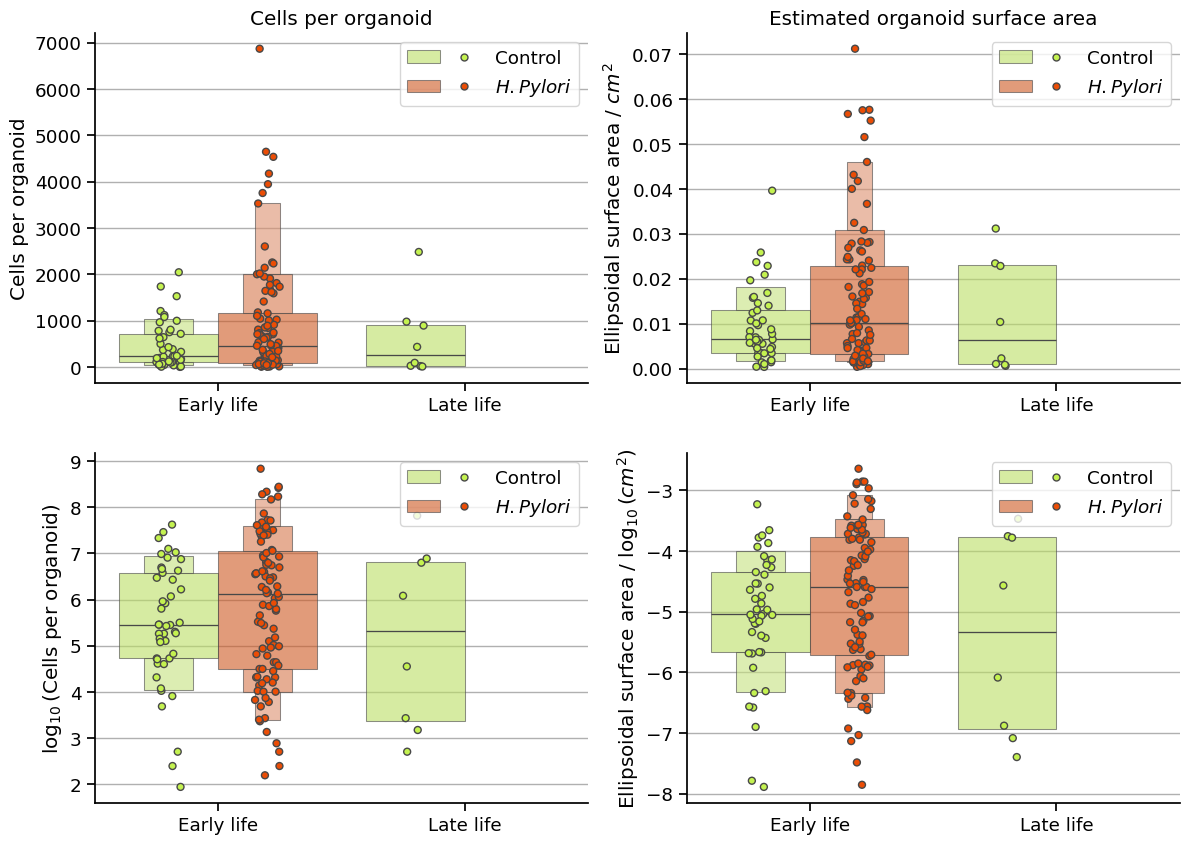

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(14,10), ncols=2, nrows=2)
for ax, feature, y_label, title in zip([ax1, ax2, ax3, ax4],
                                       ['number cells top half', 'Ellipsoid_surface_area', 'n_cells_log', 'Ellipsoid_surface_area_log'],
                                       ['Cells per organoid', 'Ellipsoidal surface area / $cm^2$', r'$\log_{10}$(Cells per organoid)', r'Ellipsoidal surface area / $\log_{10}(cm^2)$'],
                                       ['Cells per organoid', 'Estimated organoid surface area', '', '']):
    # Your boxenplot and stripplot code
    sns.boxenplot(data=DataTrusted, 
                y= feature, 
                x='Infection_time', 
                hue='Category',
                log_scale=False, 
                palette=['#c4f250', '#eb4d05'],
                box_kws={'alpha': 0.6},
                showfliers=False,
                ax=ax
                )

    sns.stripplot(data=DataTrusted,
                y= feature,
                hue="Category", 
                x="Infection_time", 
                palette=['#c4f250', '#eb4d05'],
                dodge=True,
                edgecolor='gray',
                linewidth=1,
                jitter=0.1,
                ax=ax
                )

    # Legend code (unchanged)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=['Control', '$\it{H. Pylori}$'],
            loc='best', handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None)})

    # Add grid (unchanged)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(y_label)
    ax.set_xlabel('')
    ax.set_title(title)

    # Remove spine (unchanged)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)


# Show the plot
plt.show()

## 5. Analysis of Cell density

### 5.1 Statistics
The data is again transformed to log space

In [48]:
for feature in ['cells_per_area_log']:

    # Load your data (assuming you have a DataFrame called 'summary_od_Day6')
    # Make sure 'log_Area_median' and 'count' columns exist in your data

    # Fit the LME model
    random_effect   = "Replication"
    formula         = feature + " ~ Condition"
    lme_model       = smf.mixedlm(formula, data=DataTrusted, groups=DataTrusted[random_effect])

    # Get the results summary
    lme_results = lme_model.fit(method=["lbfgs"])

    # Print the summary
    print("Results for: ", feature)
    display(lme_results.summary())

c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Results for:  cells_per_area_log


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM     Dependent Variable:     cells_per_area_log
No. Observations:      150         Method:                 REML              
No. Groups:            2           Scale:                  0.2231            
Min. group size:       68          Log-Likelihood:         -103.5714         
Max. group size:       82          Converged:              Yes               
Mean group size:       75.0                                                  
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         11.232    0.067 166.760 0.000 11.100 11.364
Condition[T.Early life H. pylori]  0.065    0.082   0.796 0.426 -0.095  0.226
Condition[T.Late life Control]     0.021    0.174   0.119 0.905 -0.320  0.362
Group Var                          0.000                                     
=============================================================================

"""

##### Interpretation of result
**Cell density:**
<br>
* **Group Var:** The value (0.000) shows that there is **no significant random effect** from the repition.
* **Intercept:** The estimated intercept when the condition is the reference category (Early life Control). The log density is with high siginifcance not zero and here 11.232.
* **Condition[T.Early life H. pylori]:** This coefficient represents the difference in the cell density between Early life H. pylori and Early life Control. The positive value (0.065) suggests that Early life H. pylori has a **slightly higher cell density** compared to the reference category (Early life Control). However, the p-value (0.426) indicates that this difference is **not statistically significant**.
* **Condition[T.Late life Control]:** This coefficient represents the difference between Late life Control and Early life Control. The positive value (0.021) suggests that Early life H. pylori has a **slightly higher** cell density compared to the reference category (Early life Control). However, the p-value (0.905) indicates that this difference is **not statistically significant**.
<br>

<>:33: SyntaxWarning: invalid escape sequence '\i'
<>:33: SyntaxWarning: invalid escape sequence '\i'
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\4014898714.py:33: SyntaxWarning: invalid escape sequence '\i'
  labels=['Control', '$\it{H. Pylori}$'],
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\4014898714.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\4014898714.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,


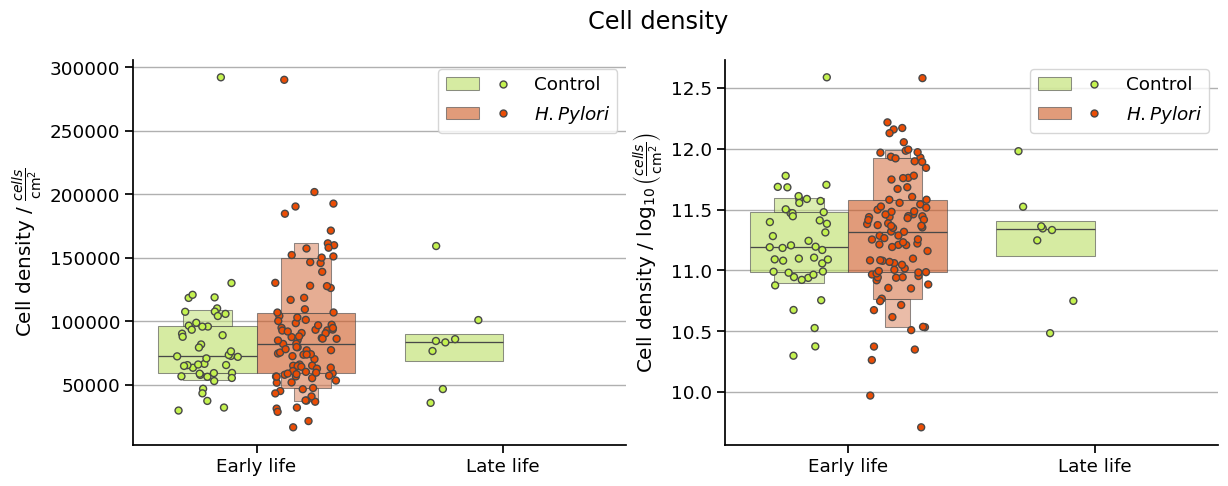

In [23]:

# Create figure and seaborn context
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(14,10), ncols=2, nrows=2)
for ax1, feature, label in zip([ax, ax2], 
                      ['cells_per_area', 'cells_per_area_log'],
                      [r'Cell density / $\frac{cells}{\mathrm{cm}^2}$', r'Cell density / $\log_{10}\left(\frac{cells}{\mathrm{cm}^2}\right)$']
                             ):
    # Create the plot
    sns.boxenplot(y=feature,
    hue="Category",
    palette=['#c4f250', '#eb4d05'],
    data=DataTrusted,
    x = 'Infection_time',
    box_kws={'alpha': 0.6},
    showfliers = False,
    ax=ax1
    )

    sns.stripplot(data=DataTrusted,
    y=feature,
    hue="Category", 
    x="Infection_time", 
    palette=['#c4f250', '#eb4d05'],
    dodge=True,
    edgecolor='gray',
    linewidth=1,
    jitter = 0.25,
    ax=ax1)


    handles, labels = ax1.get_legend_handles_labels()

    ax1.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=['Control', '$\it{H. Pylori}$'],
            loc='best', handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None)})



    # Add grid
    ax1.grid(axis='y')
    ax1.set_axisbelow(True)
    ax1.set_ylabel(label)
    ax1.set_xlabel('')


    # Remove spine
    for s in ["top", "right"]:
        ax1.spines[s].set_visible(False)

# Show the plot
fig.suptitle('Cell density')
plt.show()

## 6. Correlation between cell density and organoid size

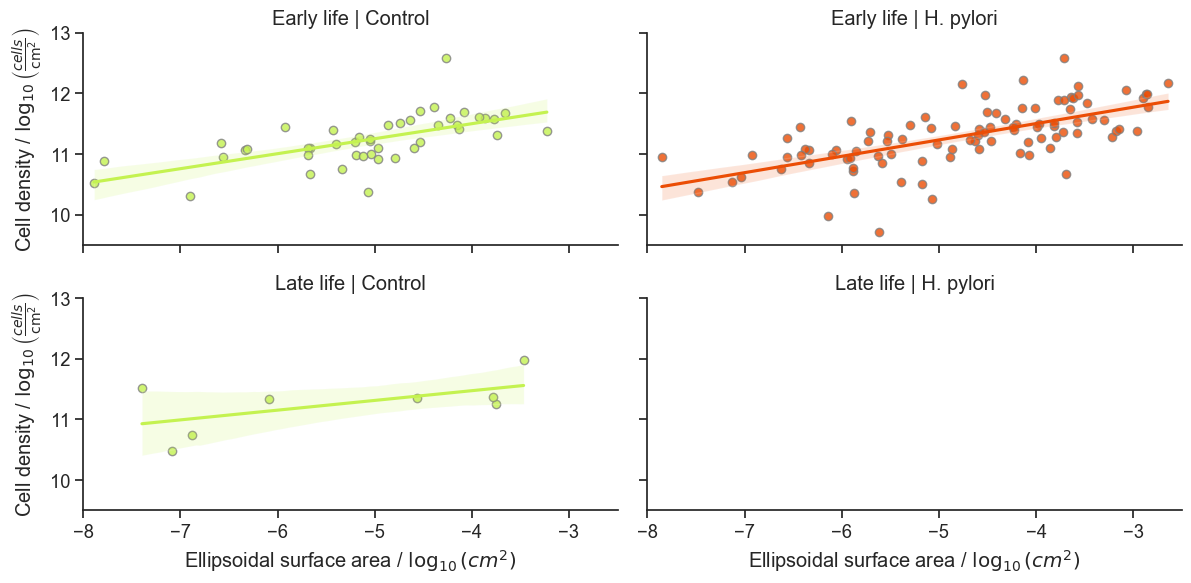

In [68]:
sns.set_style("ticks")
a=sns.FacetGrid(data= DataTrusted,
            hue="Category",
            col="Category",
            row='Infection_time',
            palette=['#c4f250', '#eb4d05'],
            height=3,
            aspect=2)
a.map(sns.regplot, 'Ellipsoid_surface_area_log',
            'cells_per_area_log',
            scatter_kws={'edgecolor':'gray','linewidths':1},
            )
a.set_titles(row_template="{row_name}", col_template="{col_name}")
a.set_axis_labels(r'Ellipsoidal surface area / $\log_{10}(cm^2)$', r'Cell density / $\log_{10}\left(\frac{cells}{\mathrm{cm}^2}\right)$')
a.set(ylim=(9.5, 13), xlim=(-8, -2.5))

For all conditions, the Cell density rises when the organoid gets bigger. The reason could be a higher stem cell density in bigger organoids.